## Cyclomatic Complexity

With these complex systems metrics we can quantify the complexity of organization structures, and other structural data. Here we compare the cyclomatic complexity of two organizations, a "Tightly Structured" organization and a "Loosely Structured" organization. Here are the two structures:

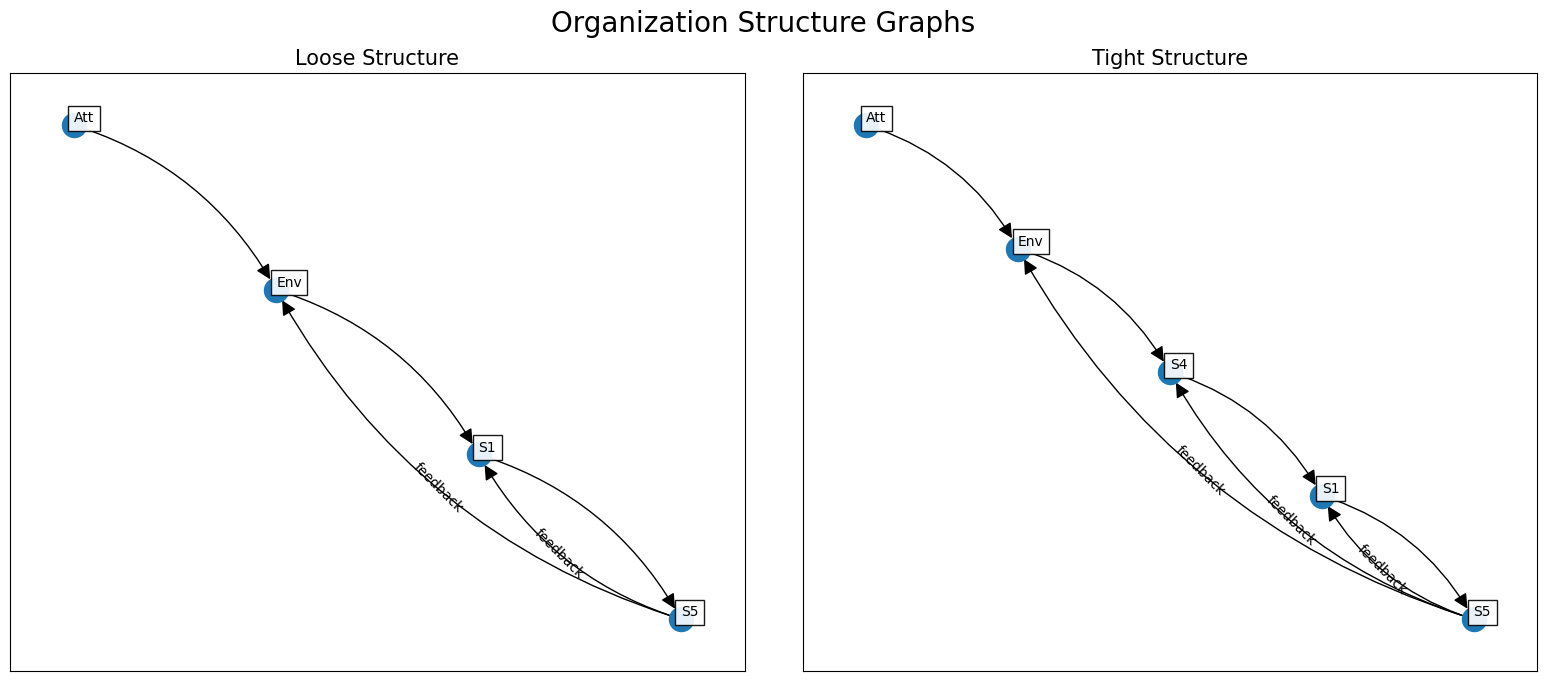

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

graphs = {}
graphs["Loose Structure"] = nx.read_gexf("simple_loose_struct.gexf")
graphs["Tight Structure"] = nx.read_gexf("simple_tight_struct.gexf")

def edge_label_pos_angle(src_pos, dest_pos, rad=0):
    sx, sy = src_pos
    dx, dy = dest_pos
    
    diff_x, diff_y = dx - sx, dy - sy
    cx, cy = (dx + sx) / 2, (dy + sy) / 2
    position = cx - diff_y * rad *.5, cy + diff_x * rad * .5
    angle = 180 * math.atan2(diff_y, diff_x) / math.pi
    if angle > 90 or angle < -90:
        angle += 180
    return position, angle

def draw(graph, ax, title="", rad=.17):
    num_nodes = len(graph)
    x_vals = nx.get_node_attributes(graph, "x")
    y_vals = nx.get_node_attributes(graph, "y")
    pos = {k:(x_vals[k], y_vals[k]) for k in graph.nodes()}
    ax.set_title(title)
    ax.title.set_size(15)
    edge_labels={(u, v): d["label"] for u, v, d in graph.edges(data=True) if "label" in d}
    nx.draw_networkx(
        graph,
        pos=pos,
        ax=ax,
        with_labels=True,
        font_size=10,
        horizontalalignment="left",
        verticalalignment="bottom",
        bbox=dict(facecolor='white', alpha=0.9),
        node_shape="o",
        arrowsize=22,
        connectionstyle="arc3,rad=-" + str(rad)
    )
    for edge, label in edge_labels.items():
        u, v = edge
        edge_pos, edge_angle = edge_label_pos_angle(pos[u], pos[v], rad)
        x, y = edge_pos
        ax.text(x, y, label, horizontalalignment='center', verticalalignment='center', rotation=edge_angle)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Organization Structure Graphs', y=1.0, size=20)
fig.tight_layout()
for title, ax in zip(graphs, (ax1, ax2)):
    draw(graphs[title], ax, title, rad=.2)

Here are the Cyclomatic Complexities of the two structures:

In [15]:
from pyrocs.complex_systems import cyclomatic_complexity as cyc_comp

print("Cyclomatic Complexity")
for title, graph in graphs.items():
    print(title + ":", cyc_comp(nx.to_numpy_array(graph)))

Cyclomatic Complexity
Loose Structure: 2
Tight Structure: 3


The extra loop in the tight organizational structure increase the cyclomatic complexity metric by 1.

## Discrete Entropy
Each node has a "type" property. For the simple networks, every node has a different type. For the complex graphs, there are multiple nodes with the S1 and S4 types. We characterize and compare graphs by applying the discrete entropy over their node type distributions

In [16]:
import pyrocs.information_theory as info

def node_type_entropy(graph):
    types = [d["type"] for _, d in graph.nodes(data=True)]
    return info.discrete_entropy(types)
    
print("Entropy of Node Type")
for title, graph in graphs.items():
    print(title + ":", node_type_entropy(graph))

Entropy of Node Type
Loose Structure: 2.0
Tight Structure: 2.3219280948873626


## Functional Redundancy
Functional Redundancy is a measure of the mean similarity of two randomly drawn elements, using a similarity metric in the range 0 to 1. We can use Functional Redundancy to measure how much redundancy there is between nodes. Node are considered fully different if they have different types. If they have the same type, they are considered similar if they point to the same outgoing nodes

In [17]:
from pyrocs.biosciences import functional_redundancy

def jaccard_index(a, b):
    if not a and not b:
        return 1
    a = set(a)
    b = set(b)
    return len(a.intersection(b)) / len(a.union(b))

def dissimilarity(graph, node_a, node_b):
    """Computes dissimilarity between two nodes.
    Returns 1 for nodes of different types, otherwise returns
    the Jaccard Distance between the sets of outgoing neighbors
    """
    a_type = graph.nodes[node_a].get("type")
    b_type = graph.nodes[node_a].get("type")
    if a_type != b_type:
        return 1
    a_neighbors = list(graph.out_edges(node_a))[0]
    b_neighbors = list(graph.out_edges(node_b))[0]
    return 1 - jaccard_index(a_neighbors, b_neighbors)
    
def fr(graph):
    nodes = list(graph)
    num_nodes = len(nodes)
    delta = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            delta[i, j] = dissimilarity(graph, nodes[i], nodes[j])
    p = np.array([1/num_nodes] * num_nodes)
    return functional_redundancy(p, delta)
    
print("Graph Functional Redundancy")
for title, graph in graphs.items():
    print(title + ":", fr(graph))

Graph Functional Redundancy
Loose Structure: 0.2777777777777777
Tight Structure: 0.20000000000000018


## Complex Organizational Structures
Applying the above metrics to more complex metrics show 

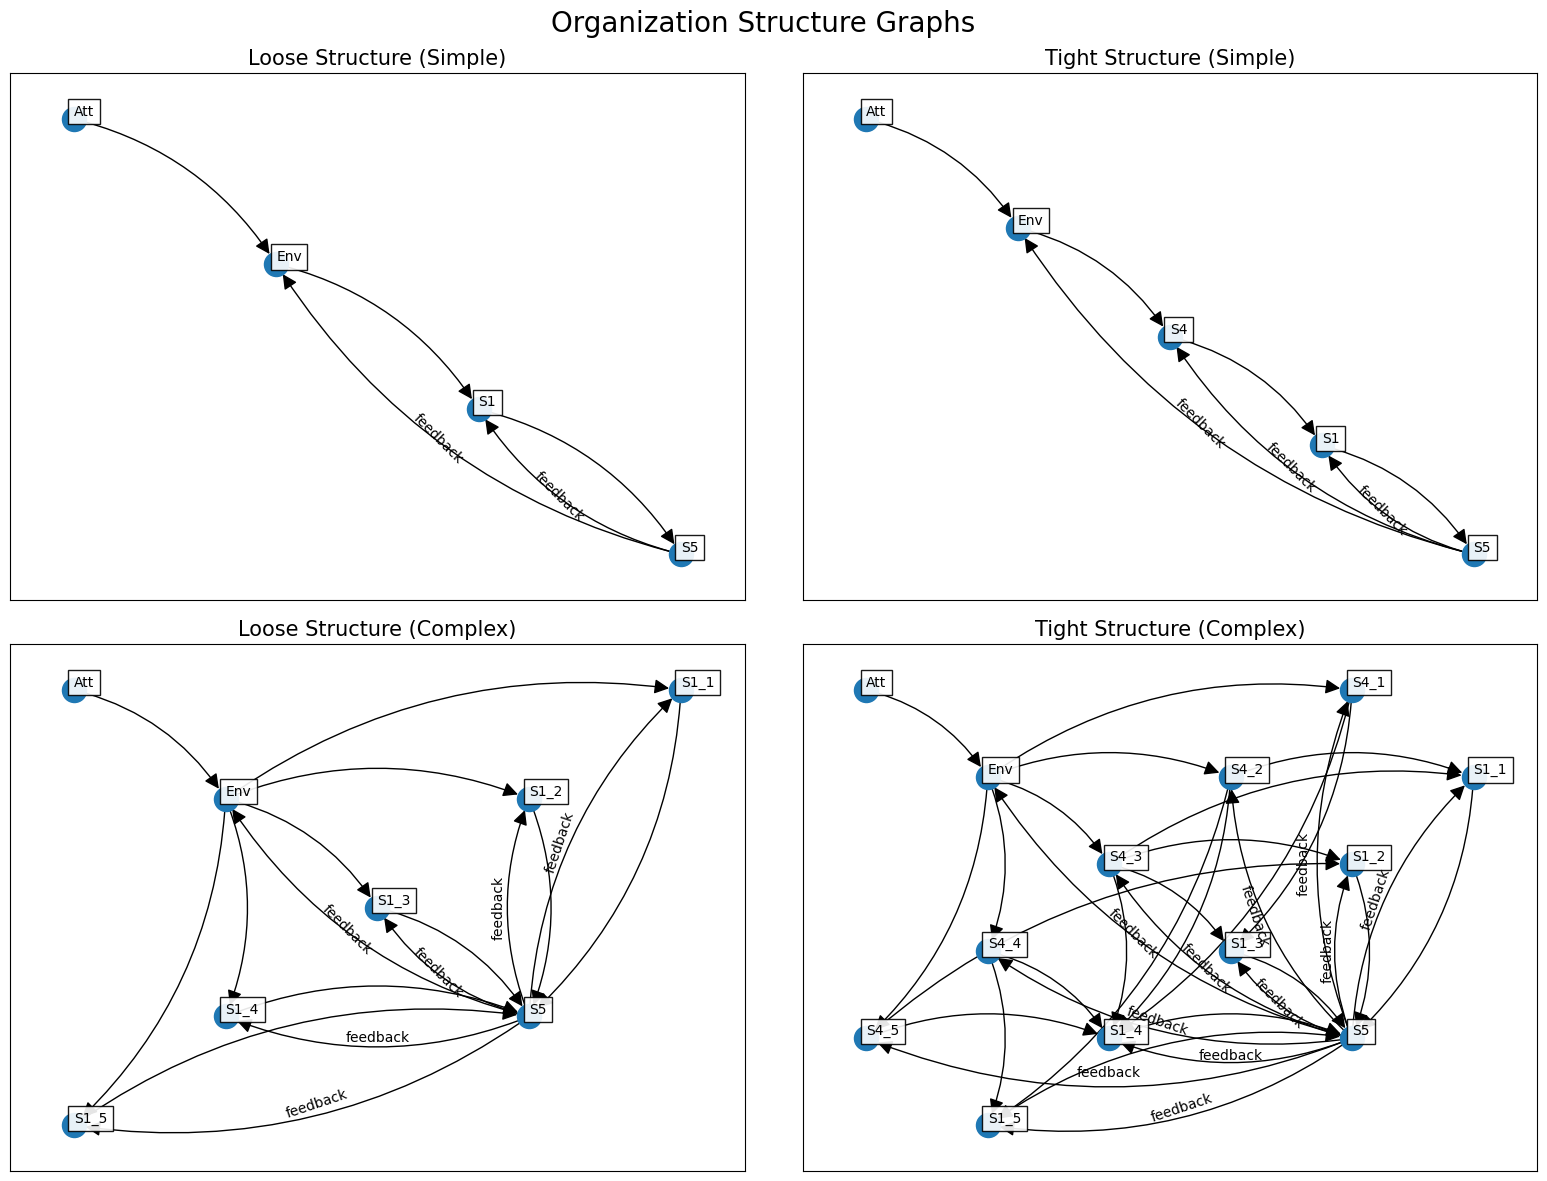

In [19]:
graphs.clear()
graphs["Loose Structure (Simple)"] = nx.read_gexf("simple_loose_struct.gexf")
graphs["Tight Structure (Simple)"] = nx.read_gexf("simple_tight_struct.gexf")
graphs["Loose Structure (Complex)"] = nx.read_gexf("complex_loose_struct.gexf")
graphs["Tight Structure (Complex)"] = nx.read_gexf("complex_tight_struct.gexf")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Organization Structure Graphs', y=1.0, size=20)
fig.tight_layout()
for title, ax in zip(graphs, (ax1, ax2, ax3, ax4)):
    draw(graphs[title], ax, title, rad=.2)

In [21]:
print("Entropy of Node Type")
for title, graph in graphs.items():
    print(title + ":", node_type_entropy(graph))
    
print("\nGraph Functional Redundancy")
for title, graph in graphs.items():
    print(title + ":", fr(graph))

Entropy of Node Type
Loose Structure (Simple): 2.0
Tight Structure (Simple): 2.3219280948873626
Loose Structure (Complex): 1.5487949406953985
Tight Structure (Complex): 1.9143411836123518

Graph Functional Redundancy
Loose Structure (Simple): 0.2777777777777777
Tight Structure (Simple): 0.20000000000000018
Loose Structure (Complex): 0.22619047619047605
Tight Structure (Complex): 0.10683760683760712
